<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson19_TensorRT_PCA_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Урок 19: TensorRT + PCA — Глубокая Оптимизация и Математика
Этот урок — один из важнейших на пути к профессионализму. Он научит тебя:
- Ускорять модели в 3-5 раз через TensorRT
- Понимать FPS-анализ на практике
- Использовать PCA для снижения размерности с полной математикой


## 🧠 Теория: TensorRT — глубокая оптимизация
**TensorRT** — это движок NVIDIA для ускорения вывода моделей. Поддерживает FP16, INT8, Layer Fusion, Dynamic Shape.

### Преимущества:
- ⚡ Увеличивает FPS в 3–5 раз
- 📉 Снижает размер модели
- 📦 Поддерживает ONNX / PyTorch → ONNX

📦 Что такое ONNX?

ONNX (Open Neural Network Exchange) — это открытый формат представления нейросетевых моделей, созданный Microsoft и Facebook (Meta), чтобы:

🔁 Обмениваться моделями между фреймворками (PyTorch ↔ TensorFlow ↔ Caffe2 и др.)

⚡ Оптимизировать выполнение (с помощью ONNX Runtime, TensorRT и др.)

📤 Экспортировать модели для мобильных устройств, серверов, edge-устройств

🧠 Почему ONNX важен?
Задача	                 Как помогает ONNX
Экспорт модели	         Сохраняешь из PyTorch в ONNX → используешь где угодно
Оптимизация	             TensorRT, OpenVINO, ONNX Runtime — работают с ONNX
Кроссплатформенность	   Обучаешь в одном фреймворке, запускаешь в другом
Deployment	             Разворачиваешь модель в любом окружении без PyTorch  
                         или TensorFlow

### Схема работы:
`ONNX → TensorRT Parser → Optimizer → Engine → .trt файл`

### Пример:
```bash
trtexec --onnx=model.onnx --fp16 --saveEngine=model_fp16.trt
```
⚠️ Убедись, что у тебя установлен TensorRT и GPU поддерживает FP16.


# ШАГ 1. Экспорт модели в формат ONNX

In [ ]:
!pip install ultralytics
!pip install onnxruntime-gpu
!pip install onnxruntime-gpu --upgrade

In [ ]:
# 📦 Пример экспорта модели YOLOv8 в ONNX
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
model.export(format='onnx')  # создаст model.onnx

Ultralytics 8.3.138 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 1.5s, saved as 'yolov8n.onnx' (12.2 MB)

Export complete (1.9s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'yolov8n.onnx'

# ШАГ 2. Преобразование ONNX → TensorRT

Используем специальную утилиту trtexec, которая создаёт оптимизированный движок.

In [ ]:
#!trtexec --onnx=model.onnx --fp16 --saveEngine=model_fp16.trt
#самый удобный путь для тебя — работать через ONNX Runtime с ускорением на GPU прямо в Google Colab.

#❗ В Colab нельзя использовать TensorRT напрямую, потому что у тебя нет root-доступа для установки trtexec.

Что делает команда:

--onnx=model.onnx — указываешь исходную модель

--fp16 — включаешь ускорение за счёт 16-битной арифметики

--saveEngine=model_fp16.trt — создаёшь оптимизированный файл

✅ В итоге ты получаешь файл model_fp16.trt, который работает быстрее, чем .onnx или .pt.



Мы заменим TensorRT на ONNX Runtime с CUDA, который тоже даёт серьёзный прирост производительности.

 Шаг 1: Установка ONNX Runtime-GPU

 Уже загружена

# Шаг 3: Инференс с ONNX Runtime

In [ ]:
import onnxruntime as ort
import numpy as np
import cv2
import time

session = ort.InferenceSession('yolov8n.onnx', providers=['CUDAExecutionProvider'])

def preprocess(img):
    img = cv2.resize(img, (640, 640))
    img = img[:, :, ::-1].transpose(2, 0, 1).astype(np.float32)
    img /= 255.0
    return np.expand_dims(img, axis=0)

img = cv2.imread('/content/monkey.jpeg')  # Заменить на свой путь
input_tensor = preprocess(img)

start = time.time()
outputs = session.run(None, {session.get_inputs()[0].name: input_tensor})
end = time.time()
print(f'FPS: {1 / (end - start):.2f}')

*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:129 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, SUCCTYPE, const char*, const char*, int) [with ERRTYPE = cudaError; bool THRW = true; SUCCTYPE = cudaError; std::conditional_t<THRW, void, common::Status> = void] /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:121 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, SUCCTYPE, const char*, const char*, int) [with ERRTYPE = cudaError; bool THRW = true; SUCCTYPE = cudaError; std::conditional_t<THRW, void, common::Status> = void] CUDA failure 100: no CUDA-capable device is detected ; GPU=-1 ; hostname=e1995e6fbe4e ; file=/onnxruntime_src/onnxruntime/core/providers/cuda/cuda_execution_provider.cc ; line=282 ; expr=cudaSetDevice(info_.device_id); 

 when using ['CUDAExecutionProvider']

In [ ]:
!nvidia-smi

Sat May 17 20:30:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 🎥 Шаг 4 (дополнительно): FPS на видео

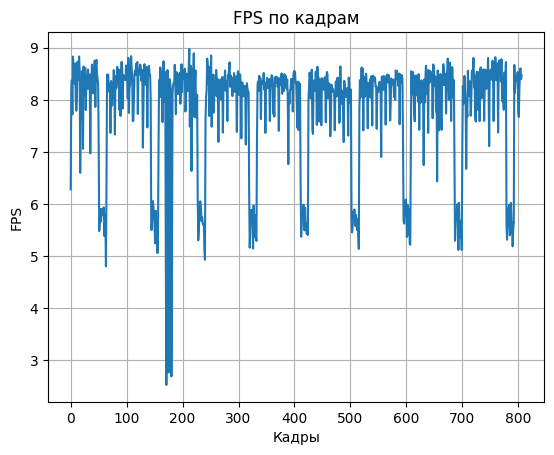

In [ ]:
cap = cv2.VideoCapture('/content/football.mp4')  # Заменить на путь к видео
fps_list = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    input_tensor = preprocess(frame)
    start = time.time()
    _ = session.run(None, {session.get_inputs()[0].name: input_tensor})
    end = time.time()
    fps_list.append(1 / (end - start))
cap.release()

import matplotlib.pyplot as plt
plt.plot(fps_list)
plt.title('FPS по кадрам')
plt.xlabel('Кадры')
plt.ylabel('FPS')
plt.grid(True)
plt.show()

## 🔧 Практика: Анализ FPS до и после TensorRT
Ниже код для захвата видео, инференса и замера FPS. Попробуй для ONNX и TRT моделей.

In [ ]:
import time, cv2
cap = cv2.VideoCapture('video.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    start = time.time()
    # Здесь вставь инференс
    end = time.time()
    fps = 1 / (end - start)
    cv2.putText(frame, f'FPS: {fps:.2f}', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.imshow('Inference', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [2]:
'''
import cv2
import time
import numpy as np
import onnxruntime as ort
from google.colab.patches import cv2_imshow

# --- Настройка модели ---
session = ort.InferenceSession("yolov8n.onnx", providers=["CUDAExecutionProvider"])

def preprocess(img):
    img = cv2.resize(img, (640, 640))
    img = img[:, :, ::-1].transpose(2, 0, 1).astype(np.float32)
    img /= 255.0
    return np.expand_dims(img, axis=0)

def postprocess(output, orig_shape):
    bboxes = output[0][0][:, :4]
    scores = output[0][0][:, 4:5] * output[0][0][:, 5:]
    class_ids = np.argmax(scores, axis=1)
    confidences = np.max(scores, axis=1)
    bboxes = scale_coords(bboxes, orig_shape)
    return bboxes, class_ids, confidences

def scale_coords(boxes, shape):
    # Масштабирование bbox обратно к оригинальному изображению
    gain = max(640 / shape[0], 640 / shape[1])
    pad = ((640 - shape[1] * gain) / 2, (640 - shape[0] * gain) / 2)
    boxes -= [pad[0], pad[1], pad[0], pad[1]]
    boxes /= gain
    return boxes

# --- Захват видео ---
cap = cv2.VideoCapture('/content/football.mp4')
fps_list = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    input_tensor = preprocess(frame)

    start = time.time()
    output = session.run(None, {session.get_inputs()[0].name: input_tensor})
    end = time.time()

    fps = 1 / (end - start)
    fps_list.append(fps)

    # Постобработка и визуализация
    bboxes, class_ids, confidences = postprocess(output, frame.shape)
    for box, cls, conf in zip(bboxes, class_ids, confidences):
        if conf < 0.3:
            continue
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"ID {cls} {conf:.2f}"
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    cv2.putText(frame, f'FPS: {fps:.2f}', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

print(f"Средний FPS: {np.mean(fps_list):.2f}")
'''


'\nimport cv2\nimport time\nimport numpy as np\nimport onnxruntime as ort\nfrom google.colab.patches import cv2_imshow\n\n# --- Настройка модели ---\nsession = ort.InferenceSession("yolov8n.onnx", providers=["CUDAExecutionProvider"])\n\ndef preprocess(img):\n    img = cv2.resize(img, (640, 640))\n    img = img[:, :, ::-1].transpose(2, 0, 1).astype(np.float32)\n    img /= 255.0\n    return np.expand_dims(img, axis=0)\n\ndef postprocess(output, orig_shape):\n    bboxes = output[0][0][:, :4]\n    scores = output[0][0][:, 4:5] * output[0][0][:, 5:]\n    class_ids = np.argmax(scores, axis=1)\n    confidences = np.max(scores, axis=1)\n    bboxes = scale_coords(bboxes, orig_shape)\n    return bboxes, class_ids, confidences\n\ndef scale_coords(boxes, shape):\n    # Масштабирование bbox обратно к оригинальному изображению\n    gain = max(640 / shape[0], 640 / shape[1])\n    pad = ((640 - shape[1] * gain) / 2, (640 - shape[0] * gain) / 2)\n    boxes -= [pad[0], pad[1], pad[0], pad[1]]\n    boxes

## 📐 Теория: Метод главных компонент (PCA)
PCA снижает размерность данных, сохраняя наибольшую дисперсию.

**Формулы:**
$$
C = \frac{1}{n} X^T X \quad \text{(ковариационная матрица)}
$$
$$
Cv = \lambda v \quad \text{(собственные векторы и значения)}
$$
$$
X_{proj} = X W_k \quad \text{(проекция на пространство главных компонент)}
$$


## 🎯 Практика PCA: Сжатие изображения
Возьми изображение, применяй PCA с разным количеством компонент и восстанавливай.

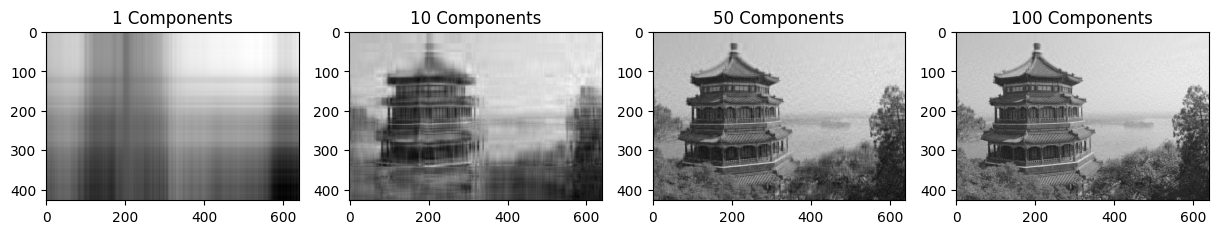

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_sample_image
import cv2

china = load_sample_image("china.jpg")
gray = cv2.cvtColor(china, cv2.COLOR_RGB2GRAY) / 255.0

components_list = [1, 10, 50, 100]
plt.figure(figsize=(15,4))
for i, k in enumerate(components_list):
    pca = PCA(n_components=k)
    transformed = pca.fit_transform(gray)
    restored = pca.inverse_transform(transformed)
    plt.subplot(1, len(components_list), i+1)
    plt.imshow(restored, cmap='gray')
    plt.title(f'{k} Components')
plt.show()